In [31]:
%pip install torch torchvision transformers datasets pillow matplotlib seaborn
%pip install groundingdino-py timm einops
%pip install huggingface_hub accelerate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import json
import logging
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Transformers and vision models
from transformers import AutoProcessor, AutoModel
import timm
from einops import rearrange, repeat

# Dataset utilities
from datasets import load_dataset

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Teacher Model

In [33]:
class GroundingDINOTeacher:
    """
    Teacher model wrapper for GroundingDINO
    Handles model loading, feature extraction, and inference
    """
    
    def __init__(self, model_name="IDEA-RESEARCH/grounding-dino-base"):
        self.model_name = model_name
        self.device = device
        self.load_model()
    
    def load_model(self):
        """Load the pre-trained GroundingDINO model"""
        try:
            self.processor = AutoProcessor.from_pretrained(self.model_name)
            self.model = AutoModel.from_pretrained(self.model_name)
            self.model = self.model.to(self.device)
            self.model.eval()
            
            print(f"✅ GroundingDINO teacher loaded successfully")
            print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
            
        except Exception as e:
            print(f"❌ Error loading GroundingDINO: {e}")
            # Fallback to a simpler vision model for demonstration
            self.use_fallback_model()
    
    def use_fallback_model(self):
        """Fallback to a CLIP-like model for demonstration"""
        print("Using fallback CLIP model for demonstration...")
        from transformers import CLIPProcessor, CLIPModel
        
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.model = self.model.to(self.device)
        self.model.eval()
    
    def denormalize_images(self, normalized_images):
        """
        Denormalize images from ImageNet normalization back to [0, 1]
        
        Args:
            normalized_images: Tensor with ImageNet normalization applied
            
        Returns:
            Denormalized images in [0, 1] range
        """
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(normalized_images.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(normalized_images.device)
        
        # Denormalize: x = (x_norm * std) + mean
        denormalized = (normalized_images * std) + mean
        
        # Clamp to [0, 1] range to ensure valid image values
        denormalized = torch.clamp(denormalized, 0, 1)
        
        return denormalized
    
    def extract_features(self, images, text_queries=None):
        """
        Extract features from the teacher model
        
        Args:
            images: Batch of images [B, C, H, W] (can be normalized or unnormalized)
            text_queries: List of text queries (optional)
            
        Returns:
            Dictionary containing various feature representations
        """
        if text_queries is None:
            text_queries = ["object"] * images.shape[0]
        
        with torch.no_grad():
            # Check if images are normalized (values outside [0, 1] range)
            if images.min() < 0 or images.max() > 1:
                # Denormalize images for the processor
                processed_images = self.denormalize_images(images)
            else:
                processed_images = images
            
            # Convert to list of PIL images for the processor
            pil_images = []
            for i in range(processed_images.shape[0]):
                img_np = processed_images[i].cpu().numpy().transpose(1, 2, 0)
                img_np = (img_np * 255).astype(np.uint8)
                pil_img = Image.fromarray(img_np)
                pil_images.append(pil_img)
            
            # Process inputs
            if hasattr(self.processor, 'image_processor'):
                # For GroundingDINO
                inputs = self.processor(
                    images=pil_images, 
                    text=text_queries, 
                    return_tensors="pt"
                ).to(self.device)
            else:
                # For CLIP fallback
                inputs = self.processor(
                    images=pil_images, 
                    text=text_queries, 
                    return_tensors="pt", 
                    padding=True
                ).to(self.device)
            
            # Get model outputs
            outputs = self.model(**inputs, output_hidden_states=True)
            
            # Extract different types of features
            features = {
                'vision_features': outputs.vision_model_output.last_hidden_state if hasattr(outputs, 'vision_model_output') else outputs.last_hidden_state,
                'pooled_features': outputs.vision_model_output.pooler_output if hasattr(outputs, 'vision_model_output') else outputs.pooler_output,
                'attention_weights': None,  # Will be extracted separately if needed
                'intermediate_features': outputs.vision_model_output.hidden_states if hasattr(outputs, 'vision_model_output') else outputs.hidden_states
            }
        
        return features

## Student Models

In [34]:
class ViTStudent(nn.Module):
    """
    Vision Transformer Student Model
    Learns to mimic GroundingDINO's visual representations
    """
    
    def __init__(self, 
                 image_size=224,
                 patch_size=16,
                 embed_dim=384,
                 depth=6,
                 num_heads=6,
                 num_classes=1000):
        super().__init__()
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Patch embedding
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (image_size // patch_size) ** 2
        
        # Position embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Transformer blocks
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=depth
        )
        
        # Feature projection heads (for distillation)
        self.feature_projectors = nn.ModuleList([
            nn.Linear(embed_dim, 512),  # For matching teacher features
            nn.Linear(embed_dim, 768),  # Alternative projection
        ])
        
        # Classification head (optional)
        self.classifier = nn.Linear(embed_dim, num_classes)
        
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights"""
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x, return_features=False):
        """
        Forward pass
        
        Args:
            x: Input images [B, C, H, W]
            return_features: Whether to return intermediate features
            
        Returns:
            Dictionary containing outputs and features
        """
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # [B, embed_dim, H//patch_size, W//patch_size]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        # Add class token and position embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        
        # Store intermediate features
        features = []
        
        # Transformer layers
        for i, layer in enumerate(self.transformer.layers):
            x = layer(x)
            if return_features:
                features.append(x.clone())
        
        # Extract class token and patch tokens
        cls_token = x[:, 0]
        patch_tokens = x[:, 1:]
        
        # Feature projections
        projected_features = []
        for projector in self.feature_projectors:
            projected_features.append(projector(cls_token))
        
        # Classification
        logits = self.classifier(cls_token)
        
        output = {
            'logits': logits,
            'cls_token': cls_token,
            'patch_tokens': patch_tokens,
            'projected_features': projected_features,
            'intermediate_features': features if return_features else None
        }
        
        return output


class MAEStudent(nn.Module):
    """
    Masked Autoencoder Student Model
    Learns teacher representations through masked reconstruction
    """
    
    def __init__(self,
                 image_size=224,
                 patch_size=16,
                 embed_dim=384,
                 depth=6,
                 num_heads=6,
                 decoder_embed_dim=192,
                 decoder_depth=4,
                 decoder_num_heads=3,
                 mask_ratio=0.75):
        super().__init__()
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.mask_ratio = mask_ratio
        
        # Encoder
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (image_size // patch_size) ** 2
        
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=depth
        )
        
        # Decoder
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim)
        self.mask_token = nn.Parameter(torch.randn(decoder_embed_dim))
        
        self.decoder_pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, decoder_embed_dim))
        
        self.decoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=decoder_embed_dim,
                nhead=decoder_num_heads,
                dim_feedforward=decoder_embed_dim * 4,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=decoder_depth
        )
        
        # Prediction head
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 3)
        
        # Feature projectors for distillation
        self.feature_projectors = nn.ModuleList([
            nn.Linear(embed_dim, 512),
            nn.Linear(embed_dim, 768),
        ])
        
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights"""
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)
        nn.init.trunc_normal_(self.mask_token, std=0.02)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def random_masking(self, x, mask_ratio):
        """
        Random masking following MAE
        
        Args:
            x: [B, N, D] where N = num_patches + 1 (including cls token)
            mask_ratio: ratio of patches to mask
            
        Returns:
            x_masked: visible patches
            mask: binary mask, 0 is keep, 1 is remove
            ids_restore: indices to restore original order
        """
        B, N, D = x.shape
        len_keep = int((N - 1) * (1 - mask_ratio))  # -1 for cls token
        
        # Generate random indices (excluding cls token)
        noise = torch.rand(B, N-1, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # Keep subset of patches + cls token
        ids_keep = ids_shuffle[:, :len_keep]
        ids_keep = torch.cat([torch.zeros(B, 1, dtype=torch.long, device=x.device), ids_keep + 1], dim=1)
        
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
        # Generate binary mask: 0 is keep, 1 is remove
        mask = torch.ones([B, N-1], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        
        return x_masked, mask, ids_restore
    
    def forward(self, x, return_features=False):
        """
        Forward pass with optional masking
        
        Args:
            x: Input images [B, C, H, W]
            return_features: Whether to return intermediate features
            
        Returns:
            Dictionary containing outputs and features
        """
        B = x.shape[0]
        
        # Patch embedding
        x_patches = self.patch_embed(x)  # [B, embed_dim, H//patch_size, W//patch_size]
        x_patches = x_patches.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        # Add class token and position embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x_full = torch.cat([cls_tokens, x_patches], dim=1)
        x_full = x_full + self.pos_embed
        
        # Masking (only during training or if specifically requested)
        if self.training:
            x_visible, mask, ids_restore = self.random_masking(x_full, self.mask_ratio)
        else:
            x_visible = x_full
            mask = torch.zeros(B, self.num_patches, device=x.device)
            ids_restore = None
        
        # Encoder
        features = []
        x_encoded = x_visible
        for layer in self.encoder.layers:
            x_encoded = layer(x_encoded)
            if return_features:
                features.append(x_encoded.clone())
        
        # Feature projections from cls token
        cls_token = x_encoded[:, 0]
        projected_features = []
        for projector in self.feature_projectors:
            projected_features.append(projector(cls_token))
        
        # Decoder (for reconstruction)
        if self.training or ids_restore is not None:
            x_decoded = self.decoder_embed(x_encoded)
            
            # Add mask tokens
            mask_tokens = self.mask_token.repeat(B, ids_restore.shape[1] + 1 - x_decoded.shape[1], 1)
            x_full_decoded = torch.cat([x_decoded[:, 1:, :], mask_tokens], dim=1)  # Remove cls token
            x_full_decoded = torch.gather(x_full_decoded, dim=1, 
                                        index=ids_restore.unsqueeze(-1).repeat(1, 1, x_full_decoded.shape[2]))
            
            # Add cls token back and position embeddings
            cls_token_decoded = x_decoded[:, 0:1, :]
            x_full_decoded = torch.cat([cls_token_decoded, x_full_decoded], dim=1)
            x_full_decoded = x_full_decoded + self.decoder_pos_embed
            
            # Decoder transformer
            for layer in self.decoder.layers:
                x_full_decoded = layer(x_full_decoded)
            
            # Prediction
            reconstruction = self.decoder_pred(x_full_decoded[:, 1:, :])  # Remove cls token
        else:
            reconstruction = None
        
        output = {
            'reconstruction': reconstruction,
            'mask': mask,
            'cls_token': cls_token,
            'projected_features': projected_features,
            'intermediate_features': features if return_features else None,
            'encoded_features': x_encoded
        }
        
        return output


## Actual training

In [ ]:
class DistillationLoss(nn.Module):
    """
    Combined loss for knowledge distillation
    """
    
    def __init__(self, alpha=0.5, beta=0.5, temperature=4.0):
        super().__init__()
        self.alpha = alpha  # Weight for feature distillation
        self.beta = beta    # Weight for attention distillation
        self.temperature = temperature
        self.mse_loss = nn.MSELoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')
    
    def get_device_from_outputs(self, outputs_dict):
        """Helper function to safely get device from model outputs"""
        for key, value in outputs_dict.items():
            if isinstance(value, torch.Tensor):
                return value.device
            elif isinstance(value, (list, tuple)) and len(value) > 0:
                if isinstance(value[0], torch.Tensor):
                    return value[0].device
        return torch.device('cpu')  # fallback
    
    def feature_distillation_loss(self, student_features, teacher_features):
        """Feature-based distillation loss"""
        loss = 0
        count = 0
        
        for s_feat, t_feat in zip(student_features, teacher_features):
            if s_feat is not None and t_feat is not None:
                # Align dimensions if needed
                if s_feat.shape != t_feat.shape:
                    min_dim = min(s_feat.shape[-1], t_feat.shape[-1])
                    s_feat = s_feat[..., :min_dim]
                    t_feat = t_feat[..., :min_dim]
                
                loss += self.mse_loss(s_feat, t_feat.detach())
                count += 1
        
        return loss / max(count, 1)
    
    def reconstruction_loss(self, reconstruction, original_images, mask):
        """MAE reconstruction loss"""
        if reconstruction is None:
            return torch.tensor(0.0, device=original_images.device)
        
        # Denormalize original images if they're normalized
        if original_images.min() < 0 or original_images.max() > 1:
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(original_images.device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(original_images.device)
            original_images = (original_images * std) + mean
            original_images = torch.clamp(original_images, 0, 1)
        
        # Convert images to patches
        B, C, H, W = original_images.shape
        patch_size = 16  # Assuming 16x16 patches
        
        # Unfold operation to extract patches
        patches = original_images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        patches = patches.contiguous().view(B, C, -1, patch_size, patch_size)
        patches = patches.permute(0, 2, 1, 3, 4).contiguous()
        patches = patches.view(B, -1, C * patch_size * patch_size)
        
        # Ensure reconstruction and target have the same shape
        if reconstruction.shape[1] != patches.shape[1]:
            min_patches = min(reconstruction.shape[1], patches.shape[1])
            reconstruction = reconstruction[:, :min_patches, :]
            patches = patches[:, :min_patches, :]
            if mask is not None:
                mask = mask[:, :min_patches]
        
        # Compute MSE loss
        loss = F.mse_loss(reconstruction, patches, reduction='none')
        loss = loss.mean(dim=-1)  # Average over patch dimensions
        
        # Apply mask if provided (only compute loss on masked patches)
        if mask is not None:
            loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        else:
            loss = loss.mean()
        
        return loss
    
    def forward(self, student_outputs, teacher_outputs, original_images=None):
        """
        Compute total distillation loss
        
        Args:
            student_outputs: Dictionary of student model outputs
            teacher_outputs: Dictionary of teacher model outputs
            original_images: Original input images (for reconstruction loss)
            
        Returns:
            Dictionary containing individual and total losses
        """
        losses = {}
        
        # Get device for tensor creation
        device = self.get_device_from_outputs(student_outputs)
        
        # Feature distillation loss
        if 'projected_features' in student_outputs and 'vision_features' in teacher_outputs:
            teacher_feats = [teacher_outputs['pooled_features']] if teacher_outputs['pooled_features'] is not None else []
            if teacher_outputs['vision_features'] is not None:
                teacher_feats.append(teacher_outputs['vision_features'].mean(dim=1))  # Pool over sequence
            
            if teacher_feats and student_outputs['projected_features']:
                losses['feature_loss'] = self.feature_distillation_loss(
                    student_outputs['projected_features'],
                    teacher_feats
                )
            else:
                losses['feature_loss'] = torch.tensor(0.0, device=device)
        else:
            losses['feature_loss'] = torch.tensor(0.0, device=device)
        
        # Reconstruction loss (for MAE)
        if 'reconstruction' in student_outputs and student_outputs['reconstruction'] is not None:
            if original_images is not None:
                try:
                    losses['reconstruction_loss'] = self.reconstruction_loss(
                        student_outputs['reconstruction'],
                        original_images,
                        student_outputs.get('mask')
                    )
                except Exception as e:
                    print(f"Warning: Reconstruction loss computation failed: {e}")
                    losses['reconstruction_loss'] = torch.tensor(0.0, device=device)
            else:
                losses['reconstruction_loss'] = torch.tensor(0.0, device=device)
        else:
            losses['reconstruction_loss'] = torch.tensor(0.0, device=device)
        
        # Total loss
        losses['total_loss'] = (
            self.alpha * losses['feature_loss'] + 
            self.beta * losses['reconstruction_loss']
        )
        
        return losses


class DistillationTrainer:
    """
    Main trainer for distillation experiments with improved regularization
    """
    
    def __init__(self, 
                 teacher_model,
                 student_models,
                 train_loader,
                 val_loader=None,
                 save_dir="./distillation_results",
                 early_stopping_patience=10,
                 use_scheduler=True):
        
        self.teacher = teacher_model
        self.students = student_models
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(exist_ok=True)
        self.early_stopping_patience = early_stopping_patience
        self.use_scheduler = use_scheduler
        
        # Initialize optimizers with better hyperparameters
        self.optimizers = {}
        self.schedulers = {}
        self.loss_fn = DistillationLoss(alpha=0.7, beta=0.3)  # Favor feature distillation
        
        for name, student in self.students.items():
            # Lower learning rate and higher weight decay
            self.optimizers[name] = optim.AdamW(
                student.parameters(), 
                lr=5e-5,  # Reduced from 1e-4
                weight_decay=0.1,  # Increased from 0.05
                betas=(0.9, 0.95)  # Better for transformers
            )
            
            if self.use_scheduler:
                # Warmup + cosine schedule
                self.schedulers[name] = optim.lr_scheduler.OneCycleLR(
                    self.optimizers[name],
                    max_lr=5e-5,
                    total_steps=100 * len(self.train_loader),  # Assuming 100 epochs max
                    pct_start=0.1,  # 10% warmup
                    anneal_strategy='cos'
                )
        
        # Training history and early stopping
        self.history = {name: {'train_loss': [], 'val_loss': []} for name in self.students.keys()}
        self.best_val_losses = {name: float('inf') for name in self.students.keys()}
        self.patience_counters = {name: 0 for name in self.students.keys()}
        self.early_stopped = {name: False for name in self.students.keys()}
    
    def add_dropout_to_student(self, student, dropout_rate=0.1):
        """Add dropout to student models for better regularization"""
        for module in student.modules():
            if isinstance(module, nn.TransformerEncoderLayer):
                module.dropout = nn.Dropout(dropout_rate)
    
    def train_epoch(self, epoch):
        """Train for one epoch with improved regularization"""
        epoch_losses = {name: [] for name in self.students.keys()}
        
        for student in self.students.values():
            student.train()
            # Add dropout during training
            self.add_dropout_to_student(student, dropout_rate=0.1)
        
        print(f"Starting epoch {epoch} with {len(self.train_loader)} batches...")
        
        for batch_idx, (images, labels) in enumerate(self.train_loader):
            images = images.to(device)
            
            # Debug: Check image statistics
            if batch_idx == 0 and epoch == 0:
                print(f"Input image stats: min={images.min().item():.3f}, max={images.max().item():.3f}, shape={images.shape}")
            
            # Get teacher features
            try:
                teacher_outputs = self.teacher.extract_features(images)
                if batch_idx == 0 and epoch == 0:
                    print(f"Teacher features extracted successfully")
            except Exception as e:
                print(f"Error extracting teacher features: {e}")
                continue
            
            # Train each student (unless early stopped)
            for name, student in self.students.items():
                if self.early_stopped[name]:
                    continue
                    
                try:
                    self.optimizers[name].zero_grad()
                    
                    # Student forward pass
                    student_outputs = student(images, return_features=True)
                    
                    # Compute loss with label smoothing effect
                    losses = self.loss_fn(student_outputs, teacher_outputs, images)
                    
                    # Add L2 regularization manually (additional to weight decay)
                    l2_reg = sum(p.pow(2).sum() for p in student.parameters())
                    losses['total_loss'] = losses['total_loss'] + 1e-6 * l2_reg
                    
                    # Check for NaN losses
                    if torch.isnan(losses['total_loss']):
                        print(f"Warning: NaN loss detected for {name} at batch {batch_idx}")
                        continue
                    
                    # Backward pass with gradient clipping
                    losses['total_loss'].backward()
                    torch.nn.utils.clip_grad_norm_(student.parameters(), 0.5)  # Reduced clip value
                    self.optimizers[name].step()
                    
                    # Update learning rate scheduler
                    if self.use_scheduler:
                        self.schedulers[name].step()
                    
                    epoch_losses[name].append(losses['total_loss'].item())
                    
                except Exception as e:
                    print(f"Error training {name} at batch {batch_idx}: {e}")
                    continue
            
            if batch_idx % 10 == 0:  # More frequent logging
                loss_str = []
                for name, losses in epoch_losses.items():
                    if losses and not self.early_stopped[name]:
                        avg_loss = np.mean(losses[-5:] if len(losses) >= 5 else losses)
                        loss_str.append(f'{name}: {avg_loss:.4f}')
                    else:
                        status = "STOPPED" if self.early_stopped[name] else "N/A"
                        loss_str.append(f'{name}: {status}')
                print(f"Epoch {epoch}, Batch {batch_idx}, Losses: {loss_str}")
        
        return {name: np.mean(losses) if losses else 0.0 for name, losses in epoch_losses.items()}
    
    def validate(self):
        """Validation step with early stopping logic"""
        if self.val_loader is None:
            return {name: 0.0 for name in self.students.keys()}
        
        val_losses = {name: [] for name in self.students.keys()}
        
        for student in self.students.values():
            student.eval()
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(device)
                
                teacher_outputs = self.teacher.extract_features(images)
                
                for name, student in self.students.items():
                    if self.early_stopped[name]:
                        continue
                        
                    student_outputs = student(images, return_features=True)
                    losses = self.loss_fn(student_outputs, teacher_outputs, images)
                    val_losses[name].append(losses['total_loss'].item())
        
        # Compute average validation losses and check early stopping
        avg_val_losses = {}
        for name, losses in val_losses.items():
            if not losses:  # If no losses (model stopped)
                avg_val_losses[name] = self.best_val_losses[name]
                continue
                
            avg_loss = np.mean(losses)
            avg_val_losses[name] = avg_loss
            
            # Early stopping logic
            if avg_loss < self.best_val_losses[name]:
                self.best_val_losses[name] = avg_loss
                self.patience_counters[name] = 0
                # Save best model
                self.save_model(name, len(self.history[name]['train_loss']), avg_loss, is_best=True)
            else:
                self.patience_counters[name] += 1
                
            # Check if we should stop this model
            if self.patience_counters[name] >= self.early_stopping_patience:
                print(f" Early stopping {name} at epoch {len(self.history[name]['train_loss'])} (patience: {self.early_stopping_patience})")
                self.early_stopped[name] = True
        
        return avg_val_losses
    
    def train(self, num_epochs=30):
        """Full training loop with early stopping"""
        print(f"Starting distillation training for up to {num_epochs} epochs...")
        print(f"Early stopping patience: {self.early_stopping_patience} epochs")
        
        for epoch in range(num_epochs):
            # Check if all models have early stopped
            if all(self.early_stopped.values()):
                print(" All models have early stopped. Training complete!")
                break
                
            # Training
            train_losses = self.train_epoch(epoch)
            
            # Validation
            val_losses = self.validate()
            
            # Update history
            for name in self.students.keys():
                self.history[name]['train_loss'].append(train_losses[name])
                self.history[name]['val_loss'].append(val_losses[name])
            
            # Print progress
            if epoch % 5 == 0:
                print(f"\n Epoch {epoch} Summary:")
                for name in self.students.keys():
                    status = "STOPPED" if self.early_stopped[name] else "ACTIVE"
                    patience = self.patience_counters[name]
                    print(f"  {name}: Train={train_losses[name]:.4f}, Val={val_losses[name]:.4f}, Status={status}, Patience={patience}/{self.early_stopping_patience}")
                print()
        
        print("Training completed!")
        return self.history
    
    def save_model(self, student_name, epoch, loss, is_best=False):
        """Save model checkpoint"""
        suffix = "_best" if is_best else f"_epoch_{epoch}"
        save_path = self.save_dir / f"{student_name}{suffix}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.students[student_name].state_dict(),
            'optimizer_state_dict': self.optimizers[student_name].state_dict(),
            'loss': loss,
            'history': self.history[student_name]
        }, save_path)
        if is_best:
            print(f" Saved BEST {student_name} model (val_loss: {loss:.4f}) to {save_path}")

## Evaluation

In [36]:
def plot_training_history(history, save_dir):
    """Plot training curves for all students"""
    fig, axes = plt.subplots(1, len(history), figsize=(15, 5))
    if len(history) == 1:
        axes = [axes]
    
    for i, (name, hist) in enumerate(history.items()):
        axes[i].plot(hist['train_loss'], label='Train Loss', alpha=0.8)
        if hist['val_loss'] and any(v > 0 for v in hist['val_loss']):
            axes[i].plot(hist['val_loss'], label='Val Loss', alpha=0.8)
        
        axes[i].set_title(f'{name} Training Curves')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


def visualize_feature_maps(teacher, students, sample_images, save_dir):
    """Visualize and compare feature maps between teacher and students"""
    teacher.model.eval()
    for student in students.values():
        student.eval()
    
    print("🔍 Generating feature visualizations...")
    
    with torch.no_grad():
        # Get sample image
        sample_img = sample_images[0:1].to(device)
        
        # Teacher features
        print("Extracting teacher features...")
        teacher_outputs = teacher.extract_features(sample_img)
        
        # Student features
        student_features = {}
        for name, student in students.items():
            print(f"Extracting {name} features...")
            outputs = student(sample_img, return_features=True)
            student_features[name] = outputs
        
        # Debug: Print feature shapes
        print("\n Feature Analysis:")
        if teacher_outputs['pooled_features'] is not None:
            print(f"Teacher pooled features: {teacher_outputs['pooled_features'].shape}")
        
        for name, features in student_features.items():
            if 'projected_features' in features and features['projected_features']:
                for i, feat in enumerate(features['projected_features']):
                    print(f"{name} projected features[{i}]: {feat.shape}")
            if 'cls_token' in features and features['cls_token'] is not None:
                print(f"{name} cls token: {features['cls_token'].shape}")
        
        # Plotting
        fig, axes = plt.subplots(3, len(students) + 1, figsize=(20, 12))
        
        # Original image
        img_np = sample_img[0].cpu().numpy().transpose(1, 2, 0)
        # Denormalize if needed
        if img_np.min() < 0:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)
        
        axes[0, 0].imshow(img_np)
        axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')
        
        # Teacher feature visualization
        if teacher_outputs['pooled_features'] is not None:
            teacher_feat = teacher_outputs['pooled_features'][0].cpu().numpy()
            # Handle multi-dimensional features
            if teacher_feat.ndim > 1:
                teacher_feat = teacher_feat.flatten()
            
            # Show first 50 dimensions
            dims_to_show = min(50, len(teacher_feat))
            x_pos = range(dims_to_show)
            
            bars = axes[1, 0].bar(x_pos, teacher_feat[:dims_to_show], alpha=0.7, color='blue')
            axes[1, 0].set_title('Teacher Pooled Features', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('Feature Dimension')
            axes[1, 0].set_ylabel('Activation')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Add statistics
            axes[1, 0].text(0.02, 0.98, f'Mean: {teacher_feat.mean():.3f}\nStd: {teacher_feat.std():.3f}\nRange: [{teacher_feat.min():.3f}, {teacher_feat.max():.3f}]', 
                          transform=axes[1, 0].transAxes, verticalalignment='top', fontsize=8,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes[1, 0].text(0.5, 0.5, 'No teacher features', ha='center', va='center', fontsize=12)
            axes[1, 0].set_title('Teacher Features')
            axes[1, 0].axis('off')
        
        # Teacher vision features (if available)
        if teacher_outputs['vision_features'] is not None:
            vision_feat = teacher_outputs['vision_features'][0].mean(dim=0).cpu().numpy()  # Average over sequence
            if vision_feat.ndim > 1:
                vision_feat = vision_feat.flatten()
            
            dims_to_show = min(50, len(vision_feat))
            x_pos = range(dims_to_show)
            
            bars = axes[2, 0].bar(x_pos, vision_feat[:dims_to_show], alpha=0.7, color='green')
            axes[2, 0].set_title('Teacher Vision Features', fontsize=12, fontweight='bold')
            axes[2, 0].set_xlabel('Feature Dimension')
            axes[2, 0].set_ylabel('Activation')
            axes[2, 0].grid(True, alpha=0.3)
        else:
            axes[2, 0].text(0.5, 0.5, 'No vision features', ha='center', va='center', fontsize=12)
            axes[2, 0].set_title('Teacher Vision Features')
            axes[2, 0].axis('off')
        
        # Student feature visualizations
        colors = ['red', 'orange', 'purple', 'brown']
        for i, (name, features) in enumerate(student_features.items(), 1):
            color = colors[min(i-1, len(colors)-1)]
            
            # Projected features visualization
            if 'projected_features' in features and features['projected_features']:
                try:
                    # Use the first projection
                    student_feat = features['projected_features'][0].cpu().numpy()
                    if student_feat.ndim > 1:
                        student_feat = student_feat.flatten()
                    
                    dims_to_show = min(50, len(student_feat))
                    x_pos = range(dims_to_show)
                    
                    bars = axes[0, i].bar(x_pos, student_feat[:dims_to_show], alpha=0.7, color=color)
                    axes[0, i].set_title(f'{name} Projected Features', fontsize=12, fontweight='bold')
                    axes[0, i].set_xlabel('Feature Dimension')
                    axes[0, i].set_ylabel('Activation')
                    axes[0, i].grid(True, alpha=0.3)
                    
                    # Add statistics
                    axes[0, i].text(0.02, 0.98, f'Mean: {student_feat.mean():.3f}\nStd: {student_feat.std():.3f}', 
                                  transform=axes[0, i].transAxes, verticalalignment='top', fontsize=8,
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                except Exception as e:
                    print(f"Error plotting {name} projected features: {e}")
                    axes[0, i].text(0.5, 0.5, f'Error: {str(e)[:30]}...', ha='center', va='center', fontsize=10)
                    axes[0, i].set_title(f'{name} Projected Features (Error)')
                    axes[0, i].axis('off')
            else:
                axes[0, i].text(0.5, 0.5, 'No projected features', ha='center', va='center', fontsize=12)
                axes[0, i].set_title(f'{name} Projected Features')
                axes[0, i].axis('off')
            
            # Class token visualization
            if 'cls_token' in features and features['cls_token'] is not None:
                try:
                    cls_feat = features['cls_token'][0].cpu().numpy()
                    if cls_feat.ndim > 1:
                        cls_feat = cls_feat.flatten()
                    
                    dims_to_show = min(50, len(cls_feat))
                    x_pos = range(dims_to_show)
                    
                    bars = axes[1, i].bar(x_pos, cls_feat[:dims_to_show], alpha=0.7, color=color)
                    axes[1, i].set_title(f'{name} Class Token', fontsize=12, fontweight='bold')
                    axes[1, i].set_xlabel('Feature Dimension')
                    axes[1, i].set_ylabel('Activation')
                    axes[1, i].grid(True, alpha=0.3)
                    
                    # Add statistics
                    axes[1, i].text(0.02, 0.98, f'Mean: {cls_feat.mean():.3f}\nStd: {cls_feat.std():.3f}', 
                                  transform=axes[1, i].transAxes, verticalalignment='top', fontsize=8,
                                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                except Exception as e:
                    print(f"Error plotting {name} class token: {e}")
                    axes[1, i].text(0.5, 0.5, f'Error: {str(e)[:30]}...', ha='center', va='center', fontsize=10)
                    axes[1, i].set_title(f'{name} Class Token (Error)')
                    axes[1, i].axis('off')
            else:
                axes[1, i].text(0.5, 0.5, 'No class token', ha='center', va='center', fontsize=12)
                axes[1, i].set_title(f'{name} Class Token')
                axes[1, i].axis('off')
            
            # Patch tokens visualization (average)
            if 'patch_tokens' in features and features['patch_tokens'] is not None:
                try:
                    patch_feat = features['patch_tokens'][0].mean(dim=0).cpu().numpy()  # Average over patches
                    if patch_feat.ndim > 1:
                        patch_feat = patch_feat.flatten()
                    
                    dims_to_show = min(50, len(patch_feat))
                    x_pos = range(dims_to_show)
                    
                    bars = axes[2, i].bar(x_pos, patch_feat[:dims_to_show], alpha=0.7, color=color)
                    axes[2, i].set_title(f'{name} Avg Patch Features', fontsize=12, fontweight='bold')
                    axes[2, i].set_xlabel('Feature Dimension')
                    axes[2, i].set_ylabel('Activation')
                    axes[2, i].grid(True, alpha=0.3)
                    
                except Exception as e:
                    print(f"Error plotting {name} patch features: {e}")
                    axes[2, i].text(0.5, 0.5, f'Error: {str(e)[:30]}...', ha='center', va='center', fontsize=10)
                    axes[2, i].set_title(f'{name} Patch Features (Error)')
                    axes[2, i].axis('off')
            else:
                axes[2, i].text(0.5, 0.5, 'No patch features', ha='center', va='center', fontsize=12)
                axes[2, i].set_title(f'{name} Patch Features')
                axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.savefig(save_dir / 'feature_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Feature visualization saved!")


def compare_model_outputs(teacher, students, test_loader, save_dir, num_samples=3):
    """Compare outputs between teacher and students on test samples with correlation analysis"""
    teacher.model.eval()
    for student in students.values():
        student.eval()
    
    print("🔍 Comparing model outputs...")
    
    # Get sample batch
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images[:num_samples].to(device)
    
    with torch.no_grad():
        # Teacher predictions
        teacher_outputs = teacher.extract_features(sample_images)
        
        # Student predictions
        student_outputs = {}
        for name, student in students.items():
            outputs = student(sample_images, return_features=True)
            student_outputs[name] = outputs
        
        # Create comparison visualization
        fig, axes = plt.subplots(num_samples + 1, len(students) + 2, figsize=(20, 5*(num_samples + 1)))
        if num_samples == 0:
            axes = axes.reshape(1, -1)
        
        # Sample-wise comparison
        for i in range(num_samples):
            # Original image
            img_np = sample_images[i].cpu().numpy().transpose(1, 2, 0)
            # Denormalize if needed
            if img_np.min() < 0:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_np = (img_np * std) + mean
            img_np = np.clip(img_np, 0, 1)
            
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f'Sample {i+1}', fontsize=14, fontweight='bold')
            axes[i, 0].axis('off')
            
            # Teacher feature visualization
            if teacher_outputs['pooled_features'] is not None:
                teacher_feat = teacher_outputs['pooled_features'][i].cpu().numpy()
                if teacher_feat.ndim > 1:
                    teacher_feat = teacher_feat.flatten()
                
                dims_to_show = min(20, len(teacher_feat))
                x_pos = range(dims_to_show)
                
                axes[i, 1].bar(x_pos, teacher_feat[:dims_to_show], alpha=0.7, color='blue')
                axes[i, 1].set_title('Teacher Features')
                axes[i, 1].set_xlabel('Feature Dimension')
                axes[i, 1].set_ylabel('Activation')
                axes[i, 1].grid(True, alpha=0.3)
            else:
                axes[i, 1].text(0.5, 0.5, 'No teacher features', ha='center', va='center', fontsize=12)
                axes[i, 1].set_title('Teacher Features')
                axes[i, 1].axis('off')
            
            # Student feature visualizations
            colors = ['red', 'orange']
            for j, (name, outputs) in enumerate(student_outputs.items(), 2):
                color = colors[min(j-2, len(colors)-1)]
                
                if 'projected_features' in outputs and outputs['projected_features']:
                    try:
                        # Use the first projection for visualization
                        student_feat = outputs['projected_features'][0][i].cpu().numpy()
                        if student_feat.ndim > 1:
                            student_feat = student_feat.flatten()
                        
                        dims_to_show = min(20, len(student_feat))
                        x_pos = range(dims_to_show)
                        
                        axes[i, j].bar(x_pos, student_feat[:dims_to_show], alpha=0.7, color=color)
                        axes[i, j].set_title(f'{name} Features')
                        axes[i, j].set_xlabel('Feature Dimension')
                        axes[i, j].set_ylabel('Activation')
                        axes[i, j].grid(True, alpha=0.3)
                        
                    except Exception as e:
                        print(f"Error plotting {name} features for sample {i}: {e}")
                        axes[i, j].text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center', va='center', fontsize=10)
                        axes[i, j].set_title(f'{name} Features (Error)')
                        axes[i, j].axis('off')
                else:
                    axes[i, j].text(0.5, 0.5, 'No features', ha='center', va='center', fontsize=12)
                    axes[i, j].set_title(f'{name} Features')
                    axes[i, j].axis('off')
        
        # Feature correlation analysis (bottom row)
        axes[num_samples, 0].text(0.5, 0.5, 'Correlation\nAnalysis', ha='center', va='center', 
                                 fontsize=16, fontweight='bold')
        axes[num_samples, 0].axis('off')
        
        # Teacher feature distribution
        if teacher_outputs['pooled_features'] is not None:
            teacher_all = teacher_outputs['pooled_features'].cpu().numpy()
            if teacher_all.ndim > 2:
                teacher_all = teacher_all.reshape(teacher_all.shape[0], -1)
            
            teacher_mean = teacher_all.mean(axis=0)
            axes[num_samples, 1].hist(teacher_mean, bins=20, alpha=0.7, color='blue', density=True)
            axes[num_samples, 1].set_title('Teacher Feature Distribution')
            axes[num_samples, 1].set_xlabel('Feature Value')
            axes[num_samples, 1].set_ylabel('Density')
            axes[num_samples, 1].grid(True, alpha=0.3)
        
        # Student feature distributions and correlations
        colors = ['red', 'orange']
        for j, (name, outputs) in enumerate(student_outputs.items(), 2):
            color = colors[min(j-2, len(colors)-1)]
            
            if 'projected_features' in outputs and outputs['projected_features']:
                try:
                    student_all = outputs['projected_features'][0].cpu().numpy()
                    if student_all.ndim > 2:
                        student_all = student_all.reshape(student_all.shape[0], -1)
                    
                    student_mean = student_all.mean(axis=0)
                    
                    # Feature distribution
                    axes[num_samples, j].hist(student_mean, bins=20, alpha=0.7, color=color, density=True)
                    axes[num_samples, j].set_title(f'{name} Feature Distribution')
                    axes[num_samples, j].set_xlabel('Feature Value')
                    axes[num_samples, j].set_ylabel('Density')
                    axes[num_samples, j].grid(True, alpha=0.3)
                    
                    # Compute correlation with teacher if possible
                    if teacher_outputs['pooled_features'] is not None:
                        teacher_flat = teacher_outputs['pooled_features'].cpu().numpy().flatten()
                        student_flat = student_all.flatten()
                        
                        # Match dimensions for correlation
                        min_len = min(len(teacher_flat), len(student_flat))
                        correlation = np.corrcoef(teacher_flat[:min_len], student_flat[:min_len])[0, 1]
                        
                        axes[num_samples, j].text(0.02, 0.98, f'Corr w/ Teacher: {correlation:.3f}', 
                                                transform=axes[num_samples, j].transAxes, 
                                                verticalalignment='top', fontsize=10,
                                                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                except Exception as e:
                    print(f"Error in correlation analysis for {name}: {e}")
                    axes[num_samples, j].text(0.5, 0.5, f'Analysis Error', ha='center', va='center')
                    axes[num_samples, j].set_title(f'{name} Analysis (Error)')
                    axes[num_samples, j].axis('off')
        
def evaluate_distillation_effectiveness(teacher, students, test_loader, save_dir):
    """
    Comprehensive evaluation of distillation effectiveness with clustering metrics
    """
    print("🧪 Evaluating distillation effectiveness...")
    
    # Import clustering metrics
    try:
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score, adjusted_rand_score
        sklearn_available = True
    except ImportError:
        print(" scikit-learn not available. Installing...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'scikit-learn'])
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score, adjusted_rand_score
        sklearn_available = True
    
    teacher.model.eval()
    for student in students.values():
        student.eval()
    
    # Collect features and labels from multiple batches
    teacher_features_all = []
    student_features_all = {name: [] for name in students.keys()}
    labels_all = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            if batch_idx >= 5:  # Use more batches for better clustering analysis
                break
                
            images = images.to(device)
            labels_all.extend(labels.numpy())
            
            # Extract teacher features
            teacher_outputs = teacher.extract_features(images)
            if teacher_outputs['pooled_features'] is not None:
                teacher_features_all.append(teacher_outputs['pooled_features'].cpu().numpy())
            
            # Extract student features
            for name, student in students.items():
                outputs = student(images, return_features=True)
                if 'projected_features' in outputs and outputs['projected_features']:
                    # Use first projection
                    student_features_all[name].append(outputs['projected_features'][0].cpu().numpy())
    
    if not teacher_features_all:
        print(" No teacher features found for evaluation")
        return None
    
    # Concatenate all features
    teacher_features = np.concatenate(teacher_features_all, axis=0)
    labels_array = np.array(labels_all)
    
    # Analysis results
    results = {
        'teacher_stats': {
            'mean': float(teacher_features.mean()),
            'std': float(teacher_features.std()),
            'shape': teacher_features.shape
        },
        'student_stats': {},
        'correlations': {},
        'mse_losses': {},
        'cosine_similarities': {},
        'clustering_metrics': {}
    }
    
    # Create comprehensive visualization
    n_students = len(students)
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, n_students + 1, height_ratios=[1, 1, 1.2])
    
    # Teacher analysis
    ax_teacher_dist = fig.add_subplot(gs[0, 0])
    ax_teacher_var = fig.add_subplot(gs[1, 0])
    ax_teacher_pca = fig.add_subplot(gs[2, 0])
    
    # Teacher feature analysis
    ax_teacher_dist.hist(teacher_features.flatten(), bins=50, alpha=0.7, color='blue', density=True)
    ax_teacher_dist.set_title('Teacher Feature Distribution', fontweight='bold')
    ax_teacher_dist.set_xlabel('Feature Value')
    ax_teacher_dist.set_ylabel('Density')
    ax_teacher_dist.grid(True, alpha=0.3)
    
    # Teacher feature variance
    teacher_var = np.var(teacher_features, axis=0)
    ax_teacher_var.plot(teacher_var[:50], 'b-', alpha=0.7, linewidth=2)
    ax_teacher_var.set_title('Teacher Feature Variance', fontweight='bold')
    ax_teacher_var.set_xlabel('Feature Dimension')
    ax_teacher_var.set_ylabel('Variance')
    ax_teacher_var.grid(True, alpha=0.3)
    
    # Teacher PCA with clustering metrics
    if len(teacher_features) > 2:
        # Perform PCA
        pca_teacher = PCA(n_components=2)
        teacher_pca = pca_teacher.fit_transform(teacher_features)
        
        # K-means clustering for silhouette analysis
        n_clusters = min(len(np.unique(labels_array)), 10)  # Limit clusters
        if n_clusters > 1:
            kmeans_teacher = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            teacher_clusters = kmeans_teacher.fit_predict(teacher_features)
            
            # Calculate clustering metrics
            teacher_silhouette = silhouette_score(teacher_features, teacher_clusters)
            teacher_ari = adjusted_rand_score(labels_array[:len(teacher_clusters)], teacher_clusters)
            
            results['clustering_metrics']['teacher'] = {
                'silhouette': float(teacher_silhouette),
                'ari': float(teacher_ari),
                'n_clusters': int(n_clusters)
            }
        else:
            teacher_silhouette = 0.0
            teacher_ari = 0.0
            teacher_clusters = np.zeros(len(teacher_features))
        
        # Plot teacher PCA
        scatter = ax_teacher_pca.scatter(teacher_pca[:, 0], teacher_pca[:, 1], 
                                       c=teacher_clusters, cmap='tab20', alpha=0.6, s=20)
        ax_teacher_pca.set_title(f'Teacher\nARI: {teacher_ari:.3f}, Silhouette: {teacher_silhouette:.3f}', 
                               fontweight='bold', fontsize=12)
        ax_teacher_pca.set_xlabel(f'PC1 ({pca_teacher.explained_variance_ratio_[0]*100:.1f}% var)')
        ax_teacher_pca.set_ylabel(f'PC2 ({pca_teacher.explained_variance_ratio_[1]*100:.1f}% var)')
        ax_teacher_pca.grid(True, alpha=0.3)
    
    # Student analysis
    colors = ['red', 'orange', 'purple', 'brown']
    for i, (name, features_list) in enumerate(student_features_all.items()):
        color = colors[min(i, len(colors)-1)]
        
        if not features_list:
            continue
            
        student_features = np.concatenate(features_list, axis=0)
        
        # Ensure same number of samples for comparison
        min_samples = min(teacher_features.shape[0], student_features.shape[0])
        min_features = min(teacher_features.shape[1], student_features.shape[1])
        
        teacher_comp = teacher_features[:min_samples, :min_features]
        student_comp = student_features[:min_samples, :min_features]
        labels_comp = labels_array[:min_samples]
        
        # Basic statistics
        results['student_stats'][name] = {
            'mean': float(student_features.mean()),
            'std': float(student_features.std()),
            'shape': student_features.shape
        }
        
        # Correlation analysis
        correlation_matrix = np.corrcoef(teacher_comp.flatten(), student_comp.flatten())
        correlation = correlation_matrix[0, 1] if not np.isnan(correlation_matrix[0, 1]) else 0.0
        results['correlations'][name] = float(correlation)
        
        # MSE Loss
        mse = np.mean((teacher_comp - student_comp) ** 2)
        results['mse_losses'][name] = float(mse)
        
        # Cosine Similarity
        teacher_norm = teacher_comp / (np.linalg.norm(teacher_comp, axis=1, keepdims=True) + 1e-8)
        student_norm = student_comp / (np.linalg.norm(student_comp, axis=1, keepdims=True) + 1e-8)
        cosine_sim = np.mean(np.sum(teacher_norm * student_norm, axis=1))
        results['cosine_similarities'][name] = float(cosine_sim)
        
        # Create subplot axes for this student
        ax_student_dist = fig.add_subplot(gs[0, i+1])
        ax_student_var = fig.add_subplot(gs[1, i+1])
        ax_student_pca = fig.add_subplot(gs[2, i+1])
        
        # Feature distribution
        ax_student_dist.hist(student_features.flatten(), bins=50, alpha=0.7, color=color, density=True)
        ax_student_dist.set_title(f'{name} Feature Distribution', fontweight='bold')
        ax_student_dist.set_xlabel('Feature Value')
        ax_student_dist.set_ylabel('Density')
        ax_student_dist.grid(True, alpha=0.3)
        
        # Add correlation text
        ax_student_dist.text(0.02, 0.98, f'Corr: {correlation:.3f}\nMSE: {mse:.3f}\nCos Sim: {cosine_sim:.3f}', 
                           transform=ax_student_dist.transAxes, verticalalignment='top', fontsize=10,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Feature variance comparison
        student_var = np.var(student_features, axis=0)
        ax_student_var.plot(student_var[:50], color=color, alpha=0.7, linewidth=2, label=name)
        ax_student_var.plot(teacher_var[:50], 'b--', alpha=0.5, linewidth=1, label='Teacher')
        ax_student_var.set_title(f'{name} vs Teacher Variance', fontweight='bold')
        ax_student_var.set_xlabel('Feature Dimension')
        ax_student_var.set_ylabel('Variance')
        ax_student_var.legend()
        ax_student_var.grid(True, alpha=0.3)
        
        # Student PCA with clustering metrics
        if len(student_comp) > 2:
            # Perform PCA on student features
            pca_student = PCA(n_components=2)
            student_pca = pca_student.fit_transform(student_comp)
            
            # K-means clustering
            n_clusters_student = min(len(np.unique(labels_comp)), 10)
            if n_clusters_student > 1:
                kmeans_student = KMeans(n_clusters=n_clusters_student, random_state=42, n_init=10)
                student_clusters = kmeans_student.fit_predict(student_comp)
                
                # Calculate clustering metrics
                student_silhouette = silhouette_score(student_comp, student_clusters)
                student_ari = adjusted_rand_score(labels_comp, student_clusters)
                
                results['clustering_metrics'][name] = {
                    'silhouette': float(student_silhouette),
                    'ari': float(student_ari),
                    'n_clusters': int(n_clusters_student)
                }
            else:
                student_silhouette = 0.0
                student_ari = 0.0
                student_clusters = np.zeros(len(student_comp))
            
            # Plot student PCA
            scatter = ax_student_pca.scatter(student_pca[:, 0], student_pca[:, 1], 
                                           c=student_clusters, cmap='tab20', alpha=0.6, s=20)
            ax_student_pca.set_title(f'{name}\nARI: {student_ari:.3f}, Silhouette: {student_silhouette:.3f}', 
                                   fontweight='bold', fontsize=12)
            ax_student_pca.set_xlabel(f'PC1 ({pca_student.explained_variance_ratio_[0]*100:.1f}% var)')
            ax_student_pca.set_ylabel(f'PC2 ({pca_student.explained_variance_ratio_[1]*100:.1f}% var)')
            ax_student_pca.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'distillation_analysis_with_clustering.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a separate detailed clustering comparison
    if sklearn_available:
        create_clustering_comparison_plot(teacher_features, student_features_all, labels_array, save_dir, results)
    
    # Print comprehensive summary
    print("\n📊 COMPREHENSIVE DISTILLATION EFFECTIVENESS SUMMARY")
    print("="*80)
    
    # Teacher metrics
    if 'teacher' in results['clustering_metrics']:
        teacher_metrics = results['clustering_metrics']['teacher']
        print(f"\n TEACHER MODEL:")
        print(f"   Silhouette Score: {teacher_metrics['silhouette']:.4f}")
        print(f"   ARI Score: {teacher_metrics['ari']:.4f}")
        print(f"   Clusters Used: {teacher_metrics['n_clusters']}")
    
    # Student metrics
    for name in students.keys():
        if name in results['correlations']:
            print(f"\n {name}:")
            print(f"   Correlation with Teacher: {results['correlations'][name]:.4f}")
            print(f"   MSE Loss: {results['mse_losses'][name]:.6f}")
            print(f"   Cosine Similarity: {results['cosine_similarities'][name]:.4f}")
            
            if name in results['clustering_metrics']:
                cluster_metrics = results['clustering_metrics'][name]
                print(f"   Silhouette Score: {cluster_metrics['silhouette']:.4f}")
                print(f"   ARI Score: {cluster_metrics['ari']:.4f}")
                
                # Comprehensive interpretation
                corr = results['correlations'][name]
                cos_sim = results['cosine_similarities'][name]
                silhouette = cluster_metrics['silhouette']
                ari = cluster_metrics['ari']
                
                # Multi-metric evaluation
                scores = [corr > 0.7, cos_sim > 0.8, silhouette > 0.3, ari > 0.5]
                quality_score = sum(scores)
                
                if quality_score >= 3:
                    print(f"   EXCELLENT distillation quality ({quality_score}/4 metrics passed)")
                elif quality_score >= 2:
                    print(f"   GOOD distillation quality ({quality_score}/4 metrics passed)")
                elif quality_score >= 1:
                    print(f"    MODERATE distillation quality ({quality_score}/4 metrics passed)")
                else:
                    print(f"   POOR distillation quality ({quality_score}/4 metrics passed)")
                    print(f"     💡 Suggestions: Increase training time, adjust learning rate, or modify architecture")
    
    print("="*80)
    
    # Save results
    with open(save_dir / 'distillation_evaluation_with_clustering.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(" Comprehensive distillation evaluation completed and saved!")
    return results


def create_clustering_comparison_plot(teacher_features, student_features_all, labels_array, save_dir, results):
    """Create a detailed clustering comparison plot similar to the user's example"""
    
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, adjusted_rand_score
    
    # Create figure for detailed clustering comparison
    n_models = 1 + len(student_features_all)  # Teacher + students
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))
    if n_models == 1:
        axes = [axes]
    
    # Teacher clustering analysis
    if len(teacher_features) > 2:
        pca = PCA(n_components=2)
        teacher_pca = pca.fit_transform(teacher_features)
        
        # Use ground truth labels for clustering if available
        n_clusters = min(len(np.unique(labels_array)), len(teacher_features)//10, 20)
        n_clusters = max(2, n_clusters)  # At least 2 clusters
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(teacher_features)
        
        # Calculate metrics
        silhouette = silhouette_score(teacher_features, clusters)
        ari = adjusted_rand_score(labels_array[:len(clusters)], clusters)
        
        # Plot
        scatter = axes[0].scatter(teacher_pca[:, 0], teacher_pca[:, 1], 
                                c=clusters, cmap='tab20', alpha=0.7, s=30)
        axes[0].set_title(f'Teacher\nARI: {ari:.3f}, Silhouette: {silhouette:.3f}', 
                         fontweight='bold', fontsize=14)
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
        axes[0].grid(True, alpha=0.3)
    
    # Student clustering analysis
    colors = ['red', 'orange', 'purple', 'brown']
    for i, (name, features_list) in enumerate(student_features_all.items(), 1):
        if not features_list or i >= len(axes):
            continue
            
        student_features = np.concatenate(features_list, axis=0)
        
        # Match sample count with teacher
        min_samples = min(len(teacher_features), len(student_features))
        student_comp = student_features[:min_samples]
        labels_comp = labels_array[:min_samples]
        
        if len(student_comp) > 2:
            pca_student = PCA(n_components=2)
            student_pca = pca_student.fit_transform(student_comp)
            
            # K-means clustering
            n_clusters_student = min(len(np.unique(labels_comp)), len(student_comp)//10, 20)
            n_clusters_student = max(2, n_clusters_student)
            
            kmeans_student = KMeans(n_clusters=n_clusters_student, random_state=42, n_init=10)
            student_clusters = kmeans_student.fit_predict(student_comp)
            
            # Calculate metrics
            student_silhouette = silhouette_score(student_comp, student_clusters)
            student_ari = adjusted_rand_score(labels_comp, student_clusters)
            
            # Plot
            scatter = axes[i].scatter(student_pca[:, 0], student_pca[:, 1], 
                                    c=student_clusters, cmap='tab20', alpha=0.7, s=30)
            axes[i].set_title(f'{name}\nARI: {student_ari:.3f}, Silhouette: {student_silhouette:.3f}', 
                            fontweight='bold', fontsize=14)
            axes[i].set_xlabel(f'PC1 ({pca_student.explained_variance_ratio_[0]*100:.1f}% var)')
            axes[i].set_ylabel(f'PC2 ({pca_student.explained_variance_ratio_[1]*100:.1f}% var)')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_dir / 'clustering_comparison_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Detailed clustering comparison saved!")


# Add this to the main function after the other visualizations
def enhanced_main():
    """Enhanced main function with comprehensive evaluation"""
    print(" Starting Enhanced GroundingDINO Distillation Framework")
    print("="*70)
    
    # Create save directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = Path(f"./distillation_results_{timestamp}")
    save_dir.mkdir(exist_ok=True)
    
    # 1. Load and prepare data
    print(" Loading dataset...")
    from multiple_datasets import get_oxford_pets_dataloader
    
    train_loader = get_oxford_pets_dataloader(
        split="train[:15%]",
        batch_size=16,
        img_size=224,
        shuffle=True,
        num_workers=2
    )
    
    val_loader = get_oxford_pets_dataloader(
        split="test[:5%]",  # Increased for better evaluation
        batch_size=16,
        img_size=224,
        shuffle=False,
        num_workers=2
    )
    
    print(f" Data loaded: {len(train_loader)} train batches, {len(val_loader)} val batches")
    
    # 2. Initialize models
    print("\n Initializing models...")
    
    # Teacher model
    teacher = GroundingDINOTeacher()
    
    # Student models
    vit_student = ViTStudent(
        image_size=224,
        patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6
    ).to(device)
    
    mae_student = MAEStudent(
        image_size=224,
        patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mask_ratio=0.75
    ).to(device)
    
    students = {
        'ViT_Student': vit_student,
        'MAE_Student': mae_student
    }
    
    print(f" Models initialized:")
    for name, student in students.items():
        param_count = sum(p.numel() for p in student.parameters())
        print(f"   {name}: {param_count:,} parameters")
    
    # 3. Setup trainer with enhanced features
    print("\n Setting up enhanced trainer...")
    trainer = DistillationTrainer(
        teacher_model=teacher,
        student_models=students,
        train_loader=train_loader,
        val_loader=val_loader,
        save_dir=save_dir,
        early_stopping_patience=10
    )
    
    # 4. Train models
    print("\n Starting training with early stopping...")
    history = trainer.train(num_epochs=100)
    
    # 5. Enhanced evaluation and visualization
    print("\n Generating comprehensive analysis...")
    
    # Plot training curves
    plot_training_history(history, save_dir)
    
    # Get a sample batch for visualization
    sample_images, _ = next(iter(val_loader))
    
    # Visualize feature maps
    visualize_feature_maps(teacher, students, sample_images, save_dir)
    
    # Compare model outputs
    compare_model_outputs(teacher, students, val_loader, save_dir)
    
    # Comprehensive distillation effectiveness evaluation
    evaluation_results = evaluate_distillation_effectiveness(teacher, students, val_loader, save_dir)
    
    # Save final results
    results = {
        'history': history,
        'evaluation': evaluation_results,
        'model_configs': {
            'ViT_Student': {
                'embed_dim': 384,
                'depth': 6,
                'num_heads': 6,
                'parameters': sum(p.numel() for p in vit_student.parameters())
            },
            'MAE_Student': {
                'embed_dim': 384,
                'depth': 6,
                'num_heads': 6,
                'parameters': sum(p.numel() for p in mae_student.parameters())
            }
        }
    }
    
    with open(save_dir / 'complete_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n Enhanced distillation analysis completed!")
    print(f" All results saved to: {save_dir}")
    print("="*70)
    
    return trainer, history, save_dir, evaluation_results

## Main run

 Starting Enhanced GroundingDINO Distillation Framework
 Loading dataset...
Loading Oxford Pets dataset: train[:15%]
Oxford Pets dataset loaded: 552 samples, 35 batches
Loading Oxford Pets dataset: test[:5%]
Oxford Pets dataset loaded: 183 samples, 12 batches
 Data loaded: 35 train batches, 12 val batches

 Initializing models...
❌ Error loading GroundingDINO: The checkpoint you are trying to load has model type `grounding-dino` but Transformers does not recognize this architecture. This could be because of an issue with the checkpoint, or because your version of Transformers is out of date.
Using fallback CLIP model for demonstration...
 Models initialized:
   ViT_Student: 11,895,912 parameters
   MAE_Student: 13,550,528 parameters

 Setting up enhanced trainer...

 Starting training with early stopping...
Starting distillation training for up to 100 epochs...
Early stopping patience: 10 epochs
Starting epoch 0 with 35 batches...
Input image stats: min=-2.118, max=2.640, shape=torch.S

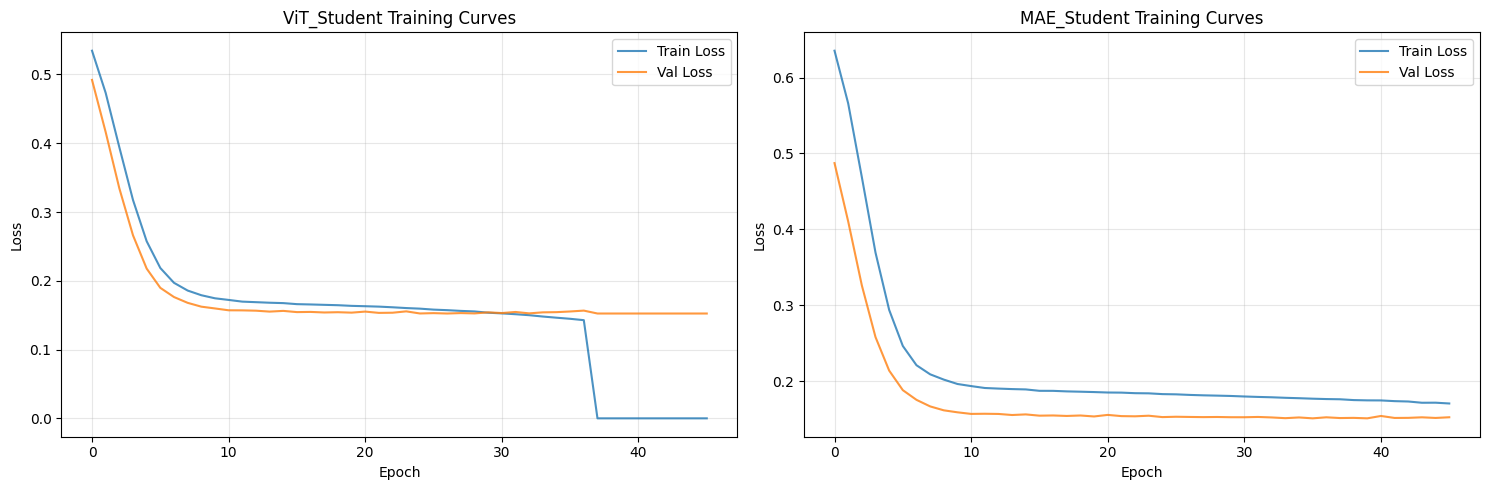

🔍 Generating feature visualizations...
Extracting teacher features...
Extracting ViT_Student features...
Extracting MAE_Student features...

 Feature Analysis:
Teacher pooled features: torch.Size([1, 768])
ViT_Student projected features[0]: torch.Size([1, 512])
ViT_Student projected features[1]: torch.Size([1, 768])
ViT_Student cls token: torch.Size([1, 384])
MAE_Student projected features[0]: torch.Size([1, 512])
MAE_Student projected features[1]: torch.Size([1, 768])
MAE_Student cls token: torch.Size([1, 384])


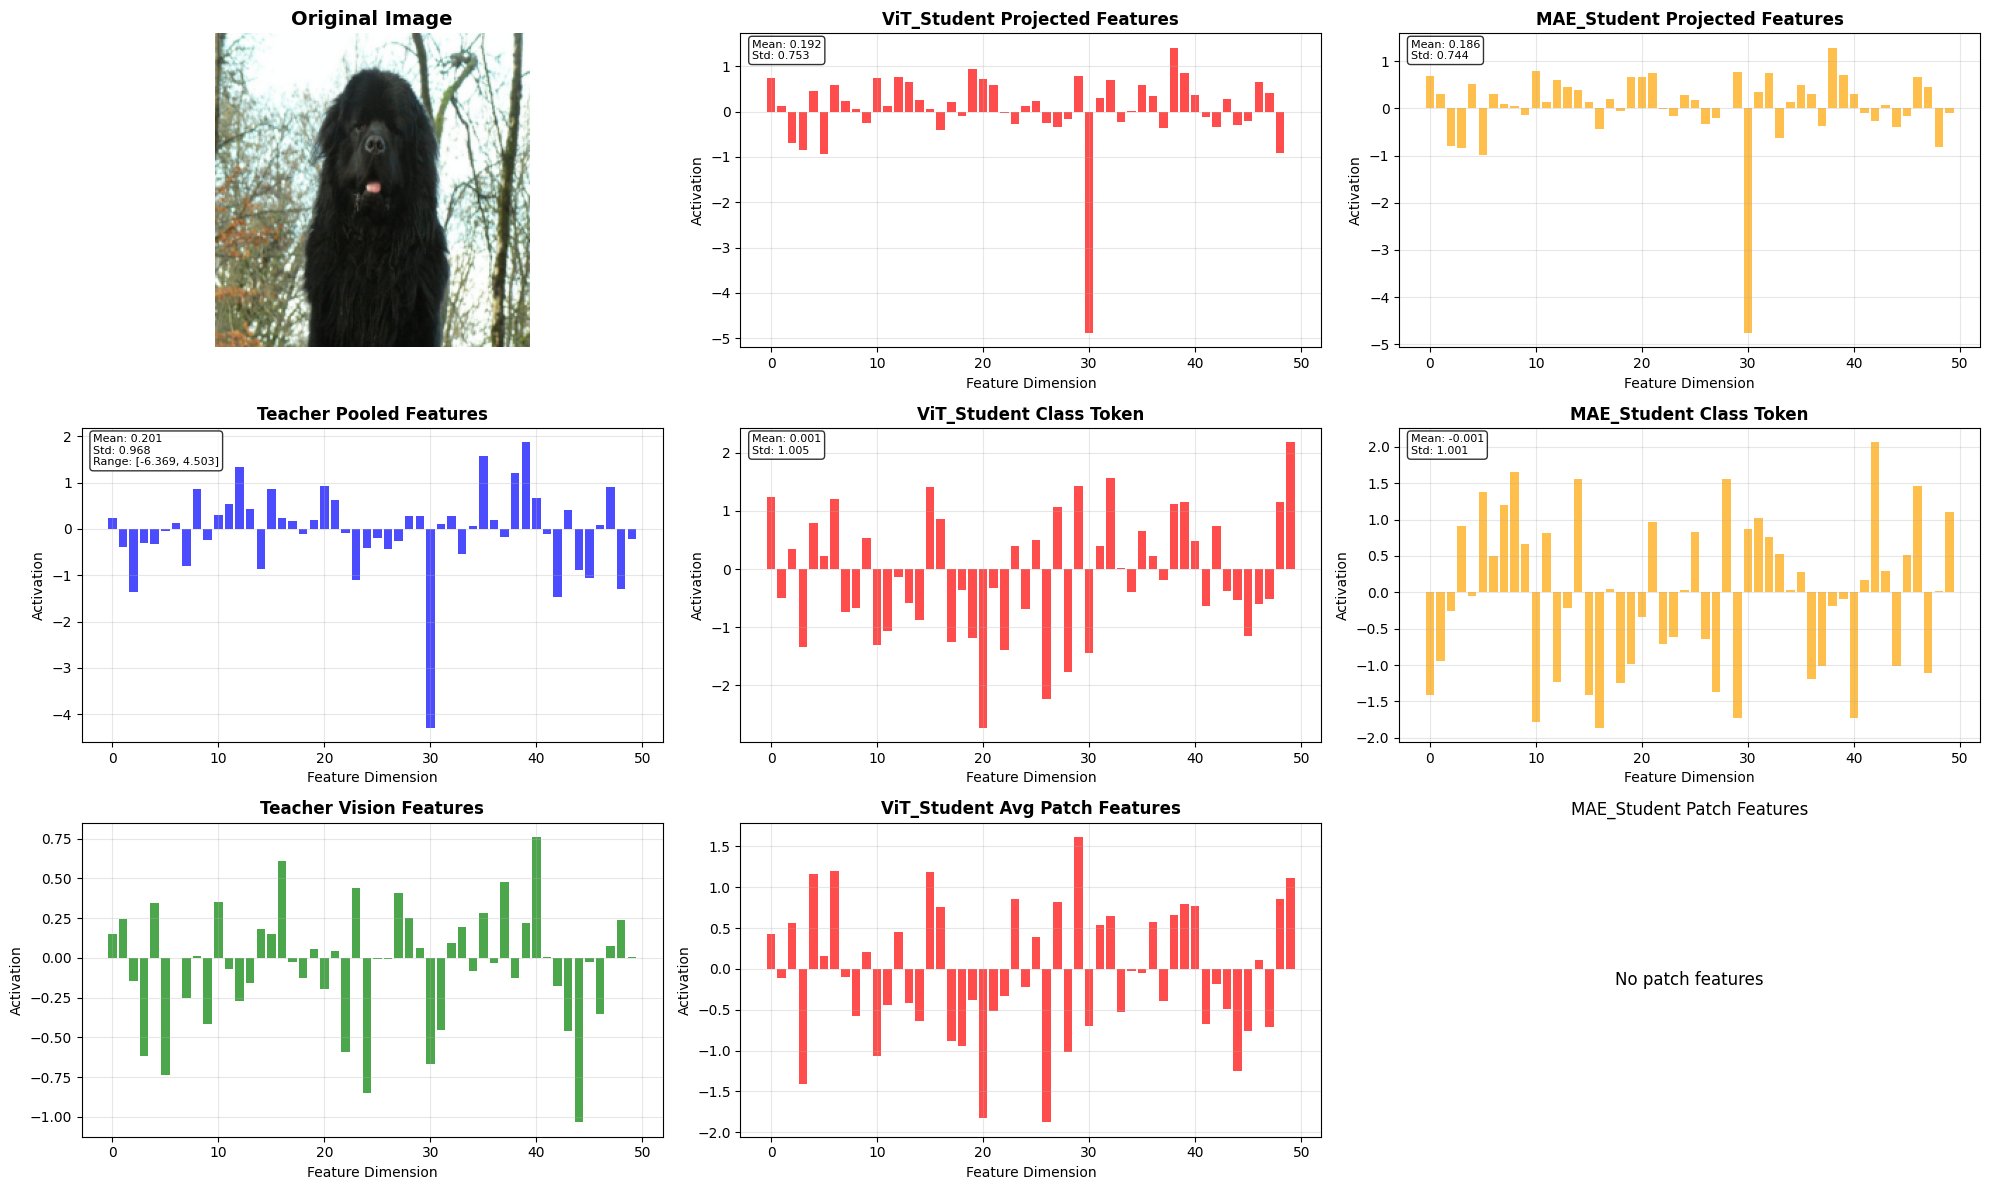

 Feature visualization saved!
🔍 Comparing model outputs...
🧪 Evaluating distillation effectiveness...


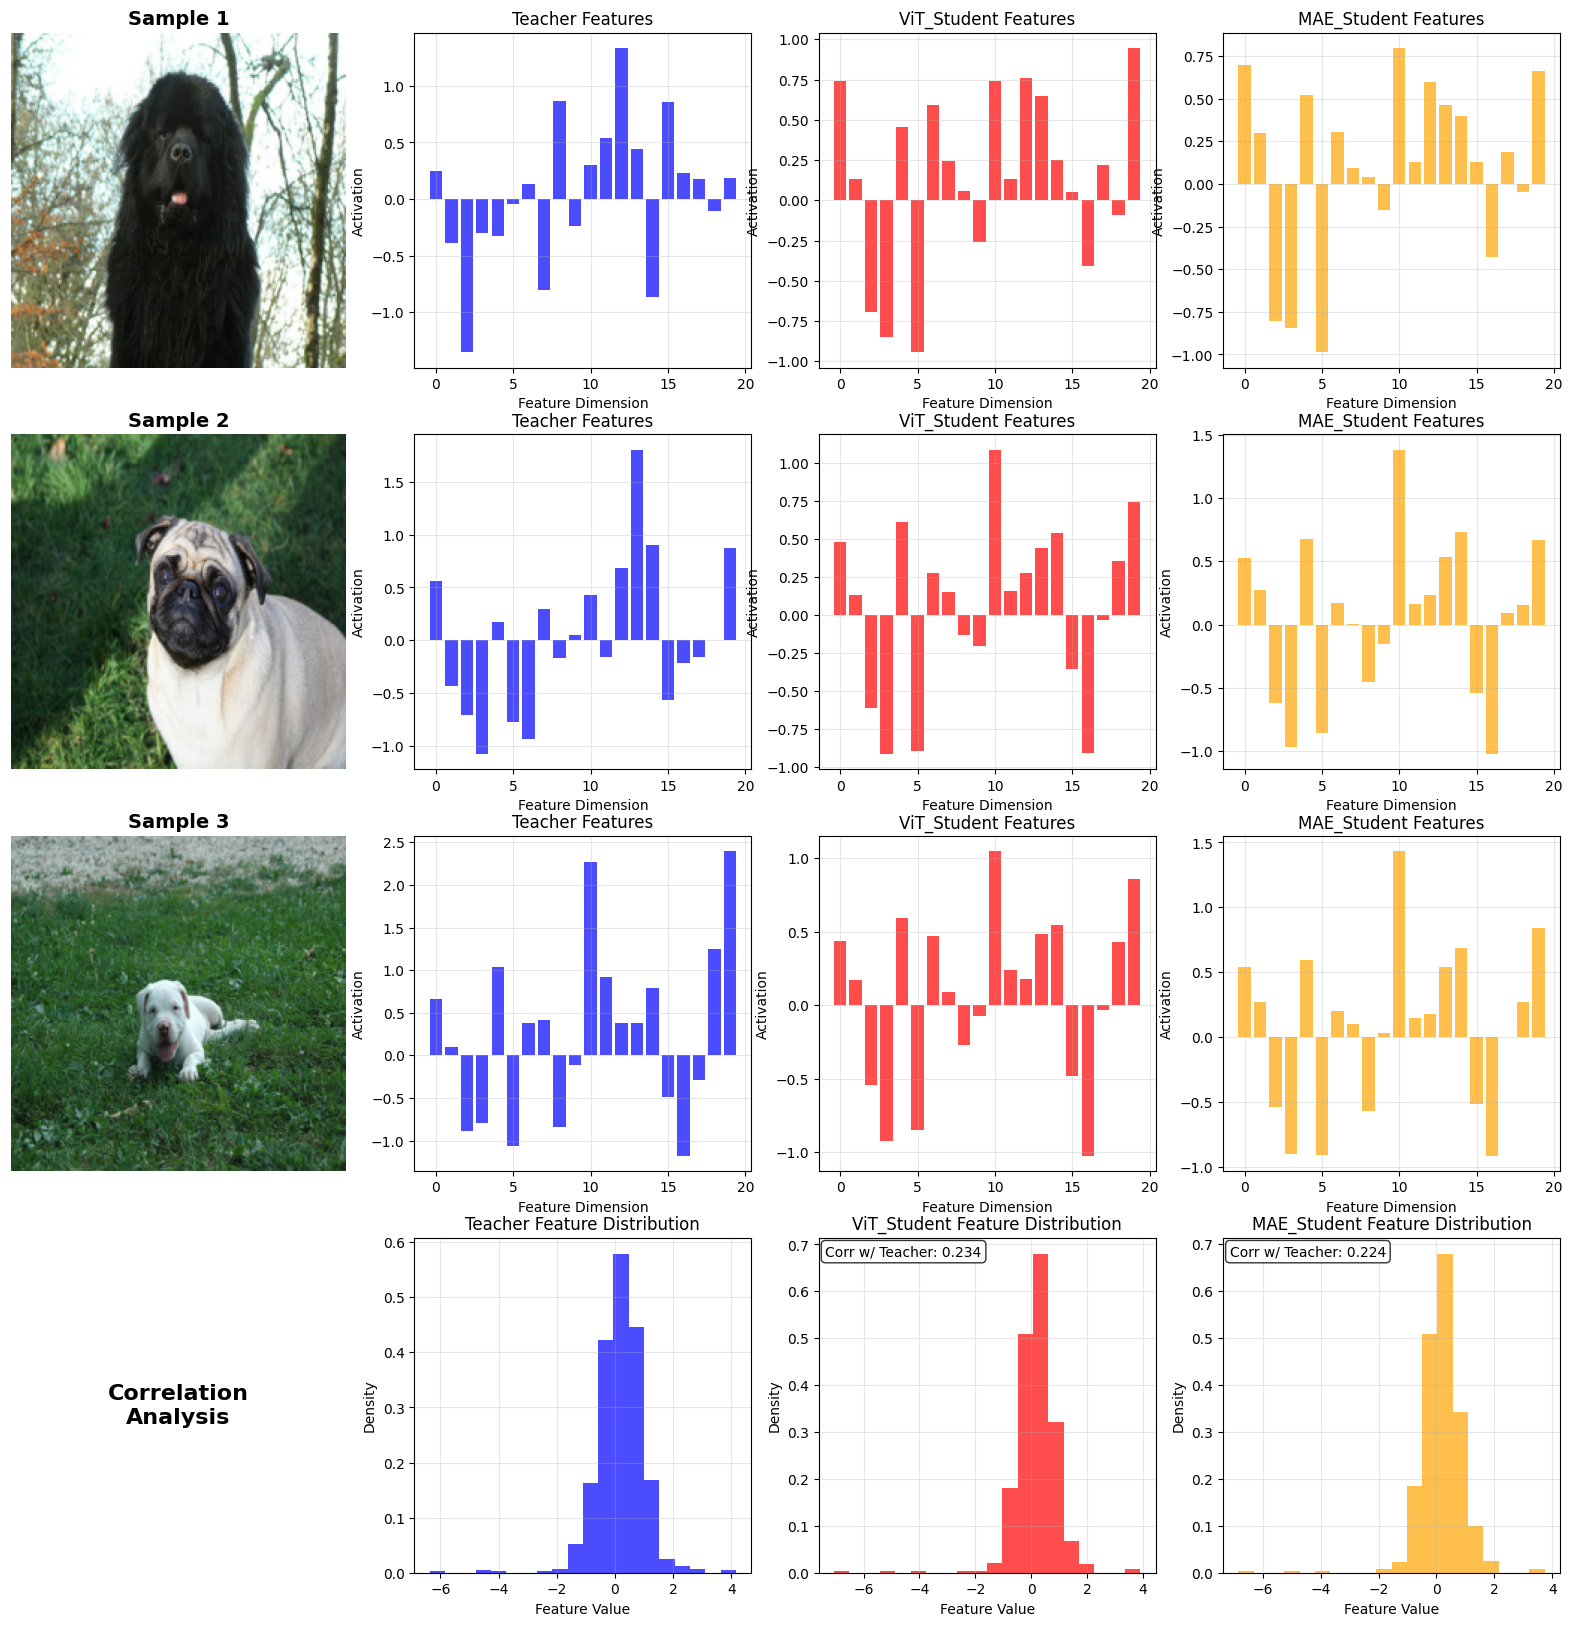

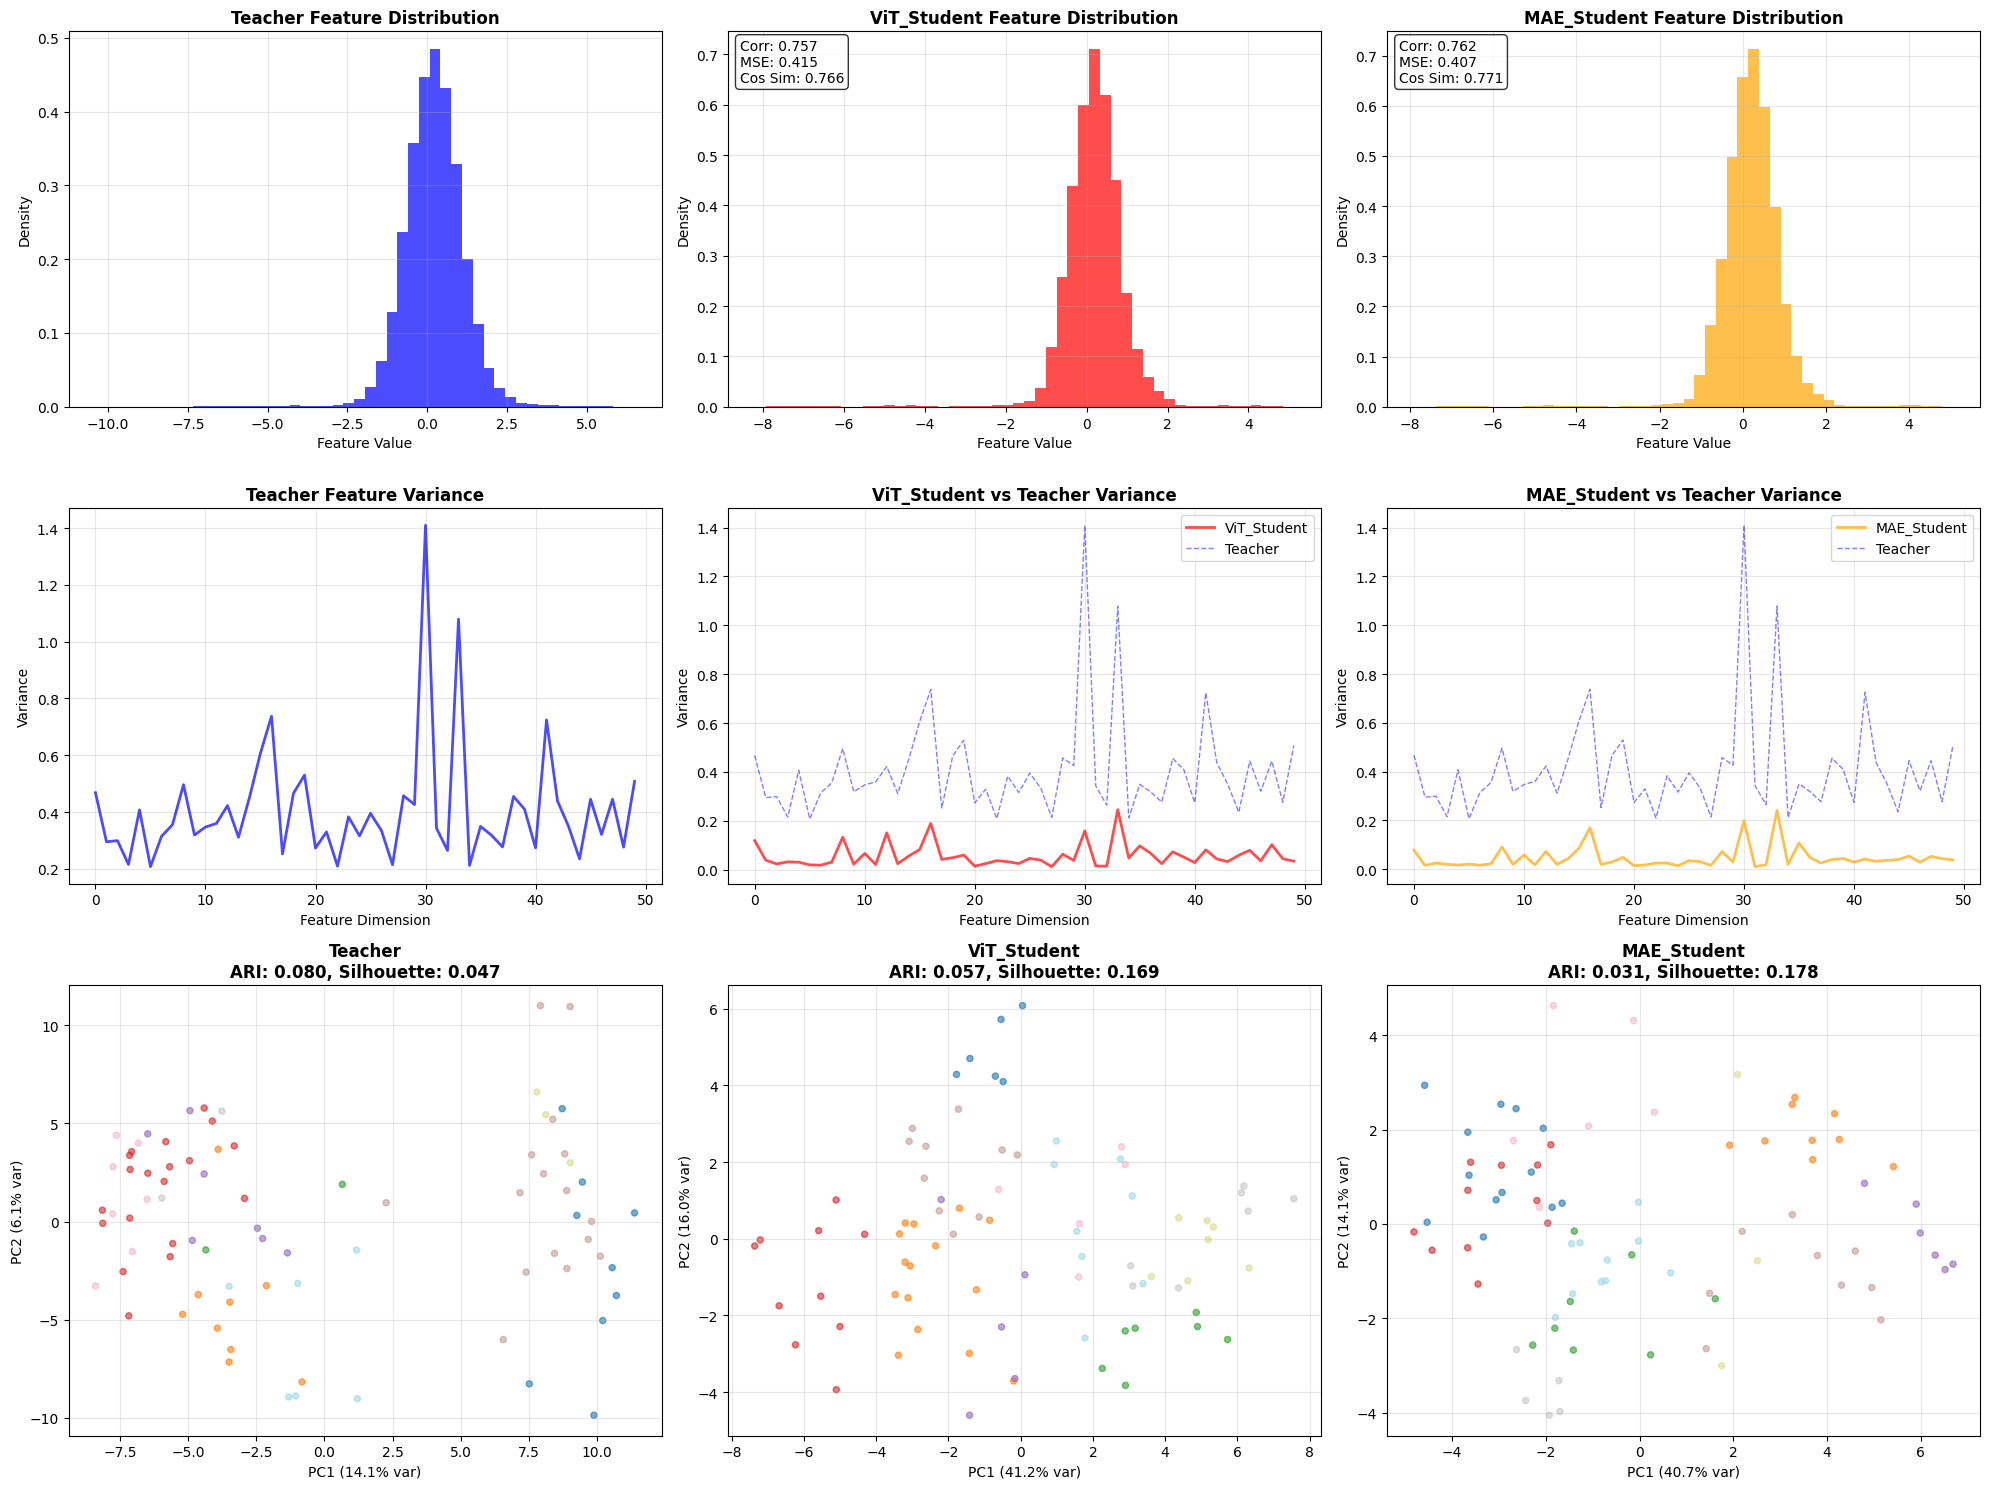

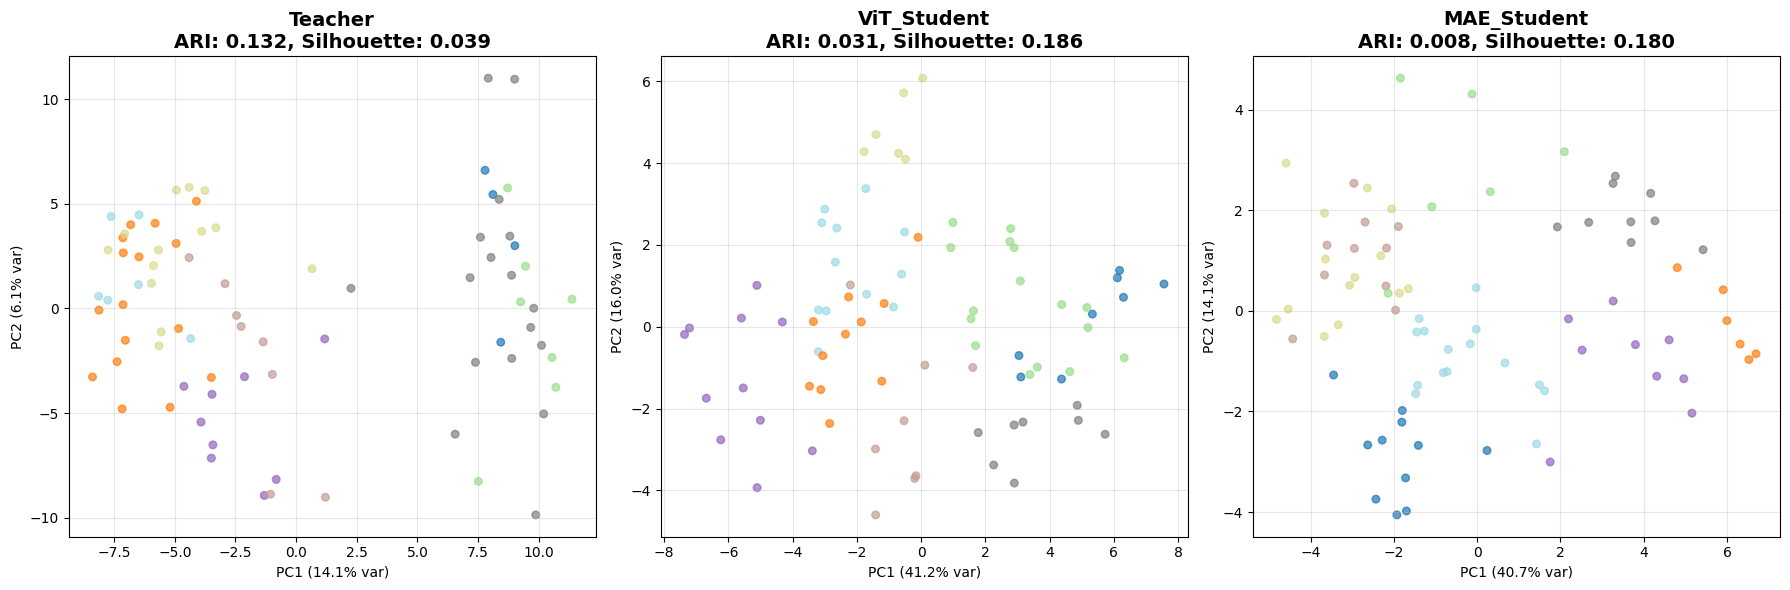

 Detailed clustering comparison saved!

📊 COMPREHENSIVE DISTILLATION EFFECTIVENESS SUMMARY

 TEACHER MODEL:
   Silhouette Score: 0.0475
   ARI Score: 0.0796
   Clusters Used: 10

 ViT_Student:
   Correlation with Teacher: 0.7573
   MSE Loss: 0.415073
   Cosine Similarity: 0.7664
   Silhouette Score: 0.1688
   ARI Score: 0.0565
    MODERATE distillation quality (1/4 metrics passed)

 MAE_Student:
   Correlation with Teacher: 0.7621
   MSE Loss: 0.407180
   Cosine Similarity: 0.7710
   Silhouette Score: 0.1781
   ARI Score: 0.0305
    MODERATE distillation quality (1/4 metrics passed)
 Comprehensive distillation evaluation completed and saved!

 Enhanced distillation analysis completed!
 All results saved to: distillation_results_20250610_103642


In [37]:
def main():
    """Main execution function"""
    print("🚀 Starting GroundingDINO Distillation Framework")
    print("="*70)
    
    # Create save directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = Path(f"./distillation_results_{timestamp}")
    save_dir.mkdir(exist_ok=True)
    
    # 1. Load and prepare data
    print(" Loading dataset...")
    from multiple_datasets import get_oxford_pets_dataloader  # Using the provided dataloader
    
    train_loader = get_oxford_pets_dataloader(
        split="train[:15%]",  # Small subset for demonstration
        batch_size=16,
        img_size=224,
        shuffle=True,
        num_workers=2
    )
    
    val_loader = get_oxford_pets_dataloader(
        split="test[:3%]",
        batch_size=16,
        img_size=224,
        shuffle=False,
        num_workers=2
    )
    
    print(f" Data loaded: {len(train_loader)} train batches, {len(val_loader)} val batches")
    
    # 2. Initialize models
    print("\n Initializing models...")
    
    # Teacher model
    teacher = GroundingDINOTeacher()
    
    # Student models
    vit_student = ViTStudent(
        image_size=224,
        patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6
    ).to(device)
    
    mae_student = MAEStudent(
        image_size=224,
        patch_size=16,
        embed_dim=384,
        depth=6,
        num_heads=6,
        mask_ratio=0.75
    ).to(device)
    
    students = {
        'ViT_Student': vit_student,
        'MAE_Student': mae_student
    }
    
    print(f" Models initialized:")
    for name, student in students.items():
        param_count = sum(p.numel() for p in student.parameters())
        print(f"   {name}: {param_count:,} parameters")
    
    # 3. Setup trainer
    print("\n Setting up trainer...")
    trainer = DistillationTrainer(
        teacher_model=teacher,
        student_models=students,
        train_loader=train_loader,
        val_loader=val_loader,
        save_dir=save_dir
    )
    
    # 4. Train models
    print("\n Starting training...")
    history = trainer.train(num_epochs=30)  # Reduced for demonstration
    
    # 5. Evaluation and visualization
    print("\n Generating visualizations...")
    
    # Plot training curves
    plot_training_history(history, save_dir)
    
    # Get a sample batch for visualization
    sample_images, _ = next(iter(val_loader))
    
    # Visualize feature maps
    visualize_feature_maps(teacher, students, sample_images, save_dir)
    
    # Compare model outputs
    compare_model_outputs(teacher, students, val_loader, save_dir)
    
    # Save final results
    results = {
        'history': history,
        'model_configs': {
            'ViT_Student': {
                'embed_dim': 384,
                'depth': 6,
                'num_heads': 6,
                'parameters': sum(p.numel() for p in vit_student.parameters())
            },
            'MAE_Student': {
                'embed_dim': 384,
                'depth': 6,
                'num_heads': 6,
                'parameters': sum(p.numel() for p in mae_student.parameters())
            }
        }
    }
    
    with open(save_dir / 'results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n Distillation completed! Results saved to: {save_dir}")
    print("="*70)
    
    return trainer, history, save_dir


# Run the enhanced main function
if __name__ == "__main__":
    # You can choose between the original main() or enhanced_main()
    # trainer, history, save_dir = main()  # Original version
    trainer, history, save_dir, evaluation_results = enhanced_main()  # Enhanced version with comprehensive analysis